In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'

# 数据预处理部分

In [2]:
#上传训练数据
train = pd.read_csv('data/train.csv')

In [3]:
#特征工程一：统计训练数据的具体信息
train_info = train.info()
print(train_info)
cat_features = list(train.select_dtypes(include=['object']).columns)
print ("离散特征共计: {} 个".format(len(cat_features)))
cont_features = [cont for cont in list(train.select_dtypes(include=['float64', 'int64']).columns) if cont not in [train.columns[-1], train.columns[0]]]
print ("连续特征共计: {}  个".format(len(cont_features)))
id_col = list(train.select_dtypes(include=['int64']).columns)
print ("数据编号特征在第一列是: {}".format(train.columns[0]))
print ("进行预测的因变量特征是: {}".format(train.columns[-1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 20.1+ MB
None
离散特征共计: 116 个
连续特征共计: 14  个
数据编号特征在第一列是: id
进行预测的因变量特征是: loss


In [4]:
#特征工程二：按照比例删除缺失数据
isnull_columns = []
isnull_percent = 0.4
for i in train.columns:
    isnull_col_percent = len(train[i][pd.isnull(train[i])])/len(train)
    if isnull_col_percent >= isnull_percent:
        isnull_columns.append(i)
train = train.drop(isnull_columns,axis=1)

In [5]:
#特征工程三：填充缺失数据，离散特征填充众数，连续特征填充均值或者中位数
cat_fuction = ""
cont_fuction = ""
cat_features = list(train.select_dtypes(include=['object']).columns)
print ("最终确定离散特征共计: {} 个".format(len(cat_features)))
cont_features = [cont for cont in list(train.select_dtypes(include=['float64', 'int64']).columns) if cont not in [train.columns[-1], train.columns[0]]]
print ("最终确定连续特征共计: {}  个".format(len(cont_features)))
id_col = list(train.select_dtypes(include=['int64']).columns)

if cat_fuction == "众数":
    train[cat_features] = train[cat_features].fillna(train[cat_features].mode())
else:  
    train[cat_features] = train[cat_features].fillna(cat_fuction)
if cont_fuction == "均值":
    train[cont_features] = train[cont_features].fillna(train[cont_features].mean())
if cont_fuction == "众数":
    train[cont_features] = train[cont_features].fillna(train[cont_features].mode())
else:
    train[cat_features] = train[cat_features].fillna("0")

最终确定离散特征共计: 116 个
最终确定连续特征共计: 14  个


In [6]:
#特征工程四：数据标准化或者归一化处理
data_processing = ""
x = train[cont_features]
if cont_fuction == "归一化":
    minMax = MinMaxScaler()
    train[cont_features] = minMax.fit_transform(x)
elif cont_fuction == "标准化":
    std = StandardScaler()
    train[cont_features] = std.fit_transform(x)
else:
    pass

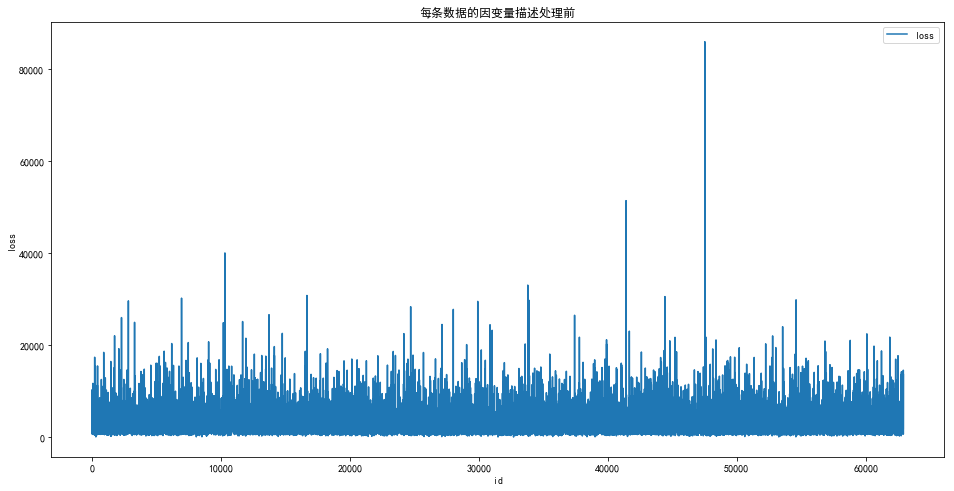

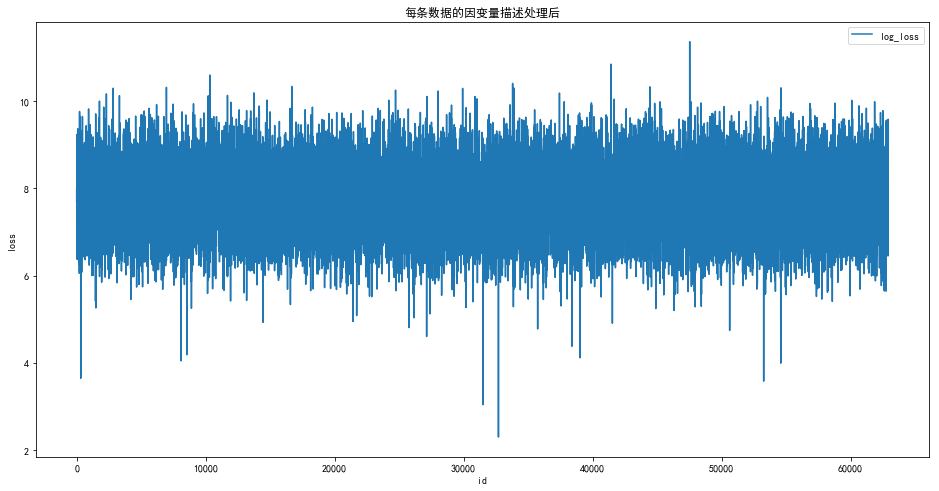

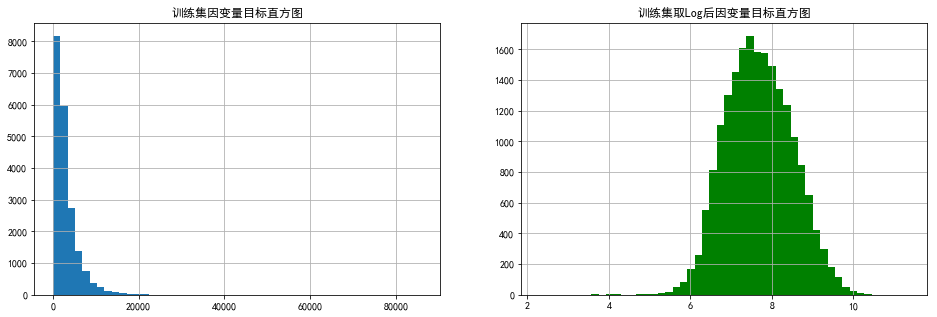

In [7]:
# 特征工程五：整理观测目标变量
# 损失值中有几个显著的峰值表示严重事故。这样的数据分布，使得这个功能非常扭曲导致的回归表现不佳。查看数据的偏态分布情况，属于正偏态即右偏分布
if float(stats.mstats.skew(train[train.columns[-1]]).data)>1:
    train['log_loss'] = np.log(train[train.columns[-1]])
    
plt.figure(figsize=(16,8))
plt.plot(train[train.columns[0]], train[train.columns[-2]])
plt.title('每条数据的因变量描述处理前')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(train[train.columns[0]], train[train.columns[-1]])
plt.title('每条数据的因变量描述处理后')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train[train.columns[-2]], bins=50)
ax1.set_title('训练集因变量目标直方图')
ax1.grid(True)
ax2.hist(np.log(train[train.columns[-2]]), bins=50, color='g')
ax2.set_title('训练集取Log后因变量目标直方图')
ax2.grid(True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247B74F17B8>,
      dtype=object)

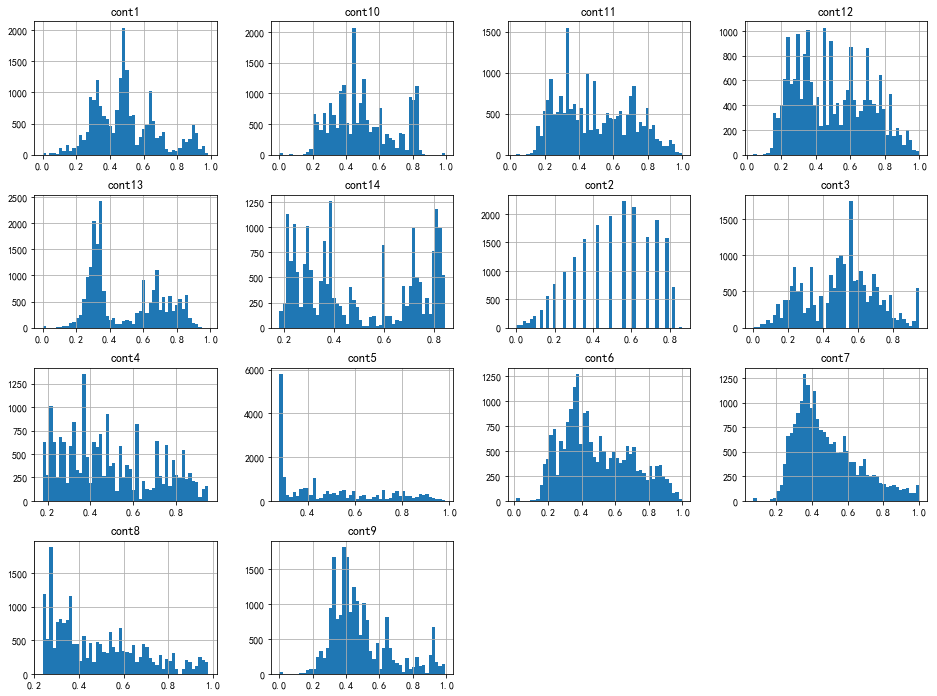

In [8]:
# 特征工程六：整理观测连续变量
cont_features_list = []
for i in cont_features:
    cont_features_list.append ((i,str(stats.mstats.skew(train[cont_features][i]).data)))
cont_features_list = pd.DataFrame(cont_features_list,columns=["变量","峰值"])
cont_features_list_json = cont_features_list.to_json()
train[cont_features].hist(bins=50, figsize=(16,12))

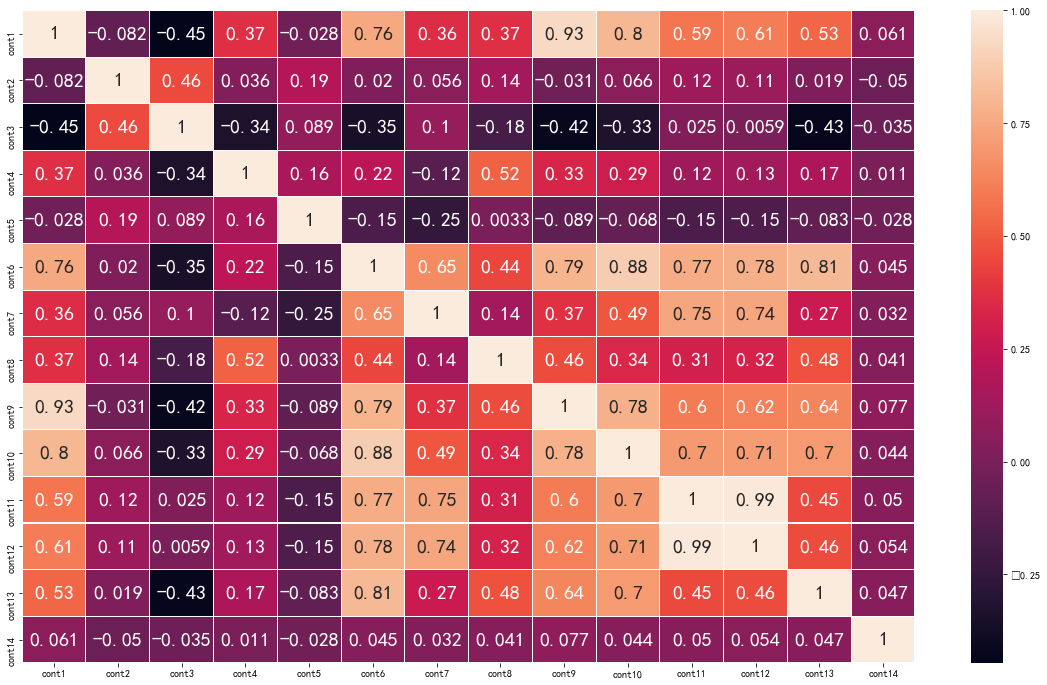

In [9]:
#特征工程七：观测连续变量相关性
plt.subplots(figsize=(20,12))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True,linewidths = 0.05,annot_kws={'size':20,'weight':'bold'})

# 模型调参与调参可视化

In [10]:
all_features = [x for x in train.columns if x not in [train.columns[0],train.columns[-2],train.columns[-1]]]
#划分自变量和因变量
train_x = train[all_features]
train_y = train[train.columns[-1]]
#将离散数据转换成哑变量
for i in range(len(cat_features)):
    train_x[cat_features[i]] = train_x[cat_features[i]].astype('category').cat.codes

D:\work tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [11]:
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pylab
pylab.mpl.rcParams['font.sans-serif'] = ['STSONG']#防止中文乱码
pylab.mpl.rcParams['axes.unicode_minus'] = False#防止中文乱码

In [12]:
cv_num = 5
verbose = 1
n_jobs = 8
scoring_fuction = 'neg_mean_squared_error'

### scoring_fuction 方法汇总
|	Scoring	|	Function	|	Comment	|
|	:-:	|	:-:	|	:-:	|
|	Classification	|
|	‘accuracy’	|	metrics.accuracy_score	|		|
|	‘balanced_accuracy’	|	metrics.balanced_accuracy_score	|	for binary targets	|
|	‘average_precision’	|	metrics.average_precision_score	|		|
|	‘brier_score_loss’	|	metrics.brier_score_loss	|		|
|	‘f1’	|	metrics.f1_score	|	for binary targets	|
|	‘f1_micro’	|	metrics.f1_score	|	micro-averaged	|
|	‘f1_macro’	|	metrics.f1_score	|	macro-averaged	|
|	‘f1_weighted’	|	metrics.f1_score	|	weighted average	|
|	‘f1_samples’	|	metrics.f1_score	|	by multilabel sample	|
|	‘neg_log_loss’	|	metrics.log_loss	|	requires predict_proba support	|
|	‘precision’ etc.	|	metrics.precision_score	|	suffixes apply as with ‘f1’	|
|	‘recall’ etc.	|	metrics.recall_score	|	suffixes apply as with ‘f1’	|
|	‘roc_auc’	|	metrics.roc_auc_score	|		|
|	Clustering	|
|	‘adjusted_mutual_info_score’	|	metrics.adjusted_mutual_info_score	|		|
|	‘adjusted_rand_score’	|	metrics.adjusted_rand_score	|		|
|	‘completeness_score’	|	metrics.completeness_score	|		|
|	‘fowlkes_mallows_score’	|	metrics.fowlkes_mallows_score	|		|
|	‘homogeneity_score’	|	metrics.homogeneity_score	|		|
|	‘mutual_info_score’	|	metrics.mutual_info_score	|		|
|	‘normalized_mutual_info_score’	|	metrics.normalized_mutual_info_score	|		|
|	‘v_measure_score’	|	metrics.v_measure_score	|		|
|	Regression	|
|	‘explained_variance’	|	metrics.explained_variance_score	|		|
|	‘neg_mean_absolute_error’	|	metrics.mean_absolute_error	|		|
|	‘neg_mean_squared_error’	|	metrics.mean_squared_error	|		|
|	‘neg_mean_squared_log_error’	|	metrics.mean_squared_log_error	|		|
|	‘neg_median_absolute_error’	|	metrics.median_absolute_error	|		|
|	‘r2’	|	metrics.r2_score	|		|  


### objective方法汇总
|	Function	|	Comment	|
|	:-:	|	:-:	|
|reg:linear |linear regression|
|reg:logistic |logistic regression|
|binary:logistic |logistic regression for binary classification, output probability|
|binary:logitraw |logistic regression for binary classification, output score before logistic transformation|
|binary:hinge |hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.count:poisson –poisson regression for count data, output mean of poisson distribution max_delta_step is set to 0.7 by default in poisson regression (used to safeguard optimization)|
|survival:cox |Cox regression for right censored survival time data (negative values are considered right censored). Note that predictions are returned on the hazard ratio scale (i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).|
|multi:softmax |set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)|
multi:softprob |same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.|
|rank:pairwise |Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized|
|rank:ndcg |Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized|
|rank:map |Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized|
|reg:gamma |gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.|
|reg:tweedie |Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.|

In [13]:
%%time
#调参过程一：max_depth和min_child_weight
cv_params = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, return_train_score=True,verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
max_depth = optimized_GBM.best_params_['max_depth']
min_child_weight = optimized_GBM.best_params_['min_child_weight']

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 15.6min finished


每次运行的结果如下:
 params:{'max_depth': 4, 'min_child_weight': 1}  mean:-0.31187684593389703   std:0.007211246535483325   rank:3
 params:{'max_depth': 4, 'min_child_weight': 3}  mean:-0.3118657983587128   std:0.006279985048894673   rank:2
 params:{'max_depth': 4, 'min_child_weight': 6}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
 params:{'max_depth': 5, 'min_child_weight': 1}  mean:-0.3181927625437906   std:0.007933284067527333   rank:6
 params:{'max_depth': 5, 'min_child_weight': 3}  mean:-0.317535129090447   std:0.007065167883544713   rank:5
 params:{'max_depth': 5, 'min_child_weight': 6}  mean:-0.3171879606703403   std:0.00462770479996245   rank:4
 params:{'max_depth': 6, 'min_child_weight': 1}  mean:-0.32427981113653304   std:0.007314215812590499   rank:8
 params:{'max_depth': 6, 'min_child_weight': 3}  mean:-0.3240996117358769   std:0.006109653337727627   rank:7
 params:{'max_depth': 6, 'min_child_weight': 6}  mean:-0.3244676064197441   std:0.007257329416471046   rank:

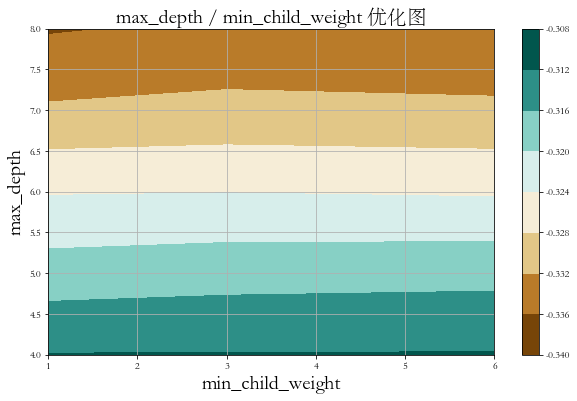

In [14]:
###图表显示参数优化程度
#热力图
# grid_visualization=[]
# for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
#     grid_visualization.append(grid_pair)
# grid_visualization=np.array(grid_visualization)
# grid_visualization.shape=(5, 3)
# sns.heatmap(grid_visualization,annot=True,linewidths = 1,annot_kws={'size':20,'weight':'bold'})
# plt.xticks(np. arange(3)+0.5,optimized_GBM.param_grid['min_child_weight'])
# plt.yticks(np. arange(5)+0.5,optimized_GBM.param_grid['max_depth'])
# plt.xlabel('min_child_weight')
# plt.ylabel('max_depth')
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['max_depth']),len(cv_params['min_child_weight']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['min_child_weight'],cv_params['max_depth'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('max_depth / min_child_weight 优化图',fontsize=20)
plt.xlabel('min_child_weight',fontsize=20)
plt.ylabel('max_depth',fontsize=20)
plt.grid(True)

In [15]:
%%time
#调参过程二：gamma
cv_params = {'gamma':[ 0.1 * i for i in range(0,5)]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'gpu:reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, return_train_score=True,verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
gamma = optimized_GBM.best_params_['gamma']

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.3min finished


每次运行的结果如下:
 params:{'gamma': 0.0}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
 params:{'gamma': 0.1}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
 params:{'gamma': 0.2}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
 params:{'gamma': 0.30000000000000004}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
 params:{'gamma': 0.4}  mean:-0.3117957035929247   std:0.0065883695547856325   rank:1
---------------------------
参数的最佳取值：{'gamma': 0.0}
最佳模型得分:-0.3117957035929247
Wall time: 1min 23s


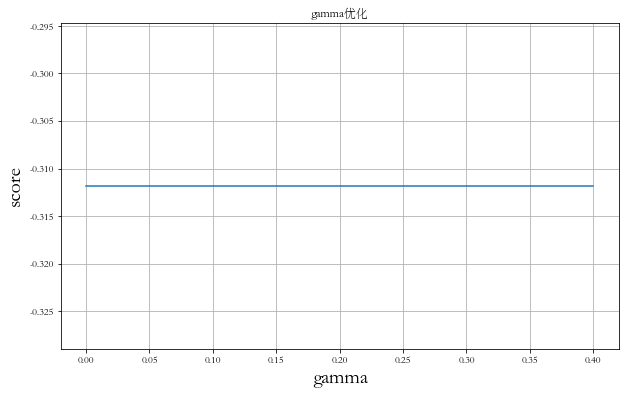

In [16]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('gamma优化')
plt.xlabel('gamma',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['gamma'], grid_visualization)
plt.grid(True)
plt.show()

In [17]:
%%time
#调参过程三：subsample以及colsample_bytree
cv_params = {'subsample':[ 0.1 * i for i in range(6,9)],'colsample_bytree':[ 0.1 * i for i in range(6,9)]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': gamma, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'gpu:reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
subsample = optimized_GBM.best_params_['subsample']
colsample_bytree = optimized_GBM.best_params_['colsample_bytree']

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  2.3min finished


每次运行的结果如下:
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001}  mean:-0.31384995303351354   std:0.005388450584514851   rank:8
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001}  mean:-0.3111412603000295   std:0.0064092915706382295   rank:3
 params:{'colsample_bytree': 0.6000000000000001, 'subsample': 0.8}  mean:-0.3109317362471681   std:0.006111704996684328   rank:2
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001}  mean:-0.3137327499188787   std:0.006431904482183757   rank:7
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001}  mean:-0.3114870666387734   std:0.005521585677025841   rank:4
 params:{'colsample_bytree': 0.7000000000000001, 'subsample': 0.8}  mean:-0.31045583660708   std:0.006213723131419718   rank:1
 params:{'colsample_bytree': 0.8, 'subsample': 0.6000000000000001}  mean:-0.3147031284649472   std:0.004895869385818384   rank:9
 params:{'colsample_bytree

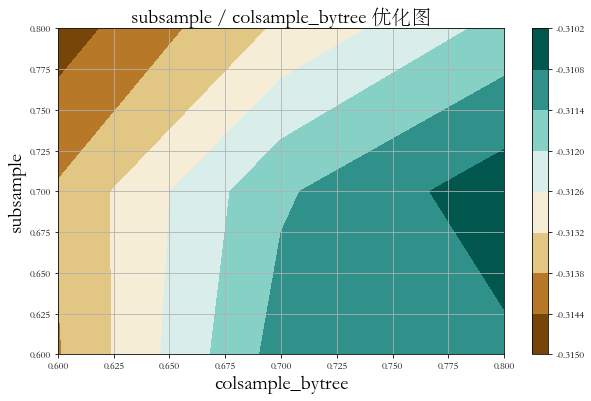

In [18]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['subsample']),len(cv_params['colsample_bytree']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['colsample_bytree'],cv_params['subsample'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('subsample / colsample_bytree 优化图',fontsize=20)
plt.xlabel('colsample_bytree',fontsize=20)
plt.ylabel('subsample',fontsize=20)
plt.grid(True)

In [19]:
%%time
#调参过程四：reg_alpha以及reg_lambda
cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': 0, 'reg_lambda': 1,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'gpu:reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
reg_alpha = optimized_GBM.best_params_['reg_alpha']
reg_lambda = optimized_GBM.best_params_['reg_lambda']

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:  6.5min finished


每次运行的结果如下:
 params:{'reg_alpha': 0.05, 'reg_lambda': 0.05}  mean:-0.31084755839385464   std:0.005537612327521445   rank:20
 params:{'reg_alpha': 0.05, 'reg_lambda': 0.1}  mean:-0.31238516227868973   std:0.005347405223941817   rank:24
 params:{'reg_alpha': 0.05, 'reg_lambda': 1}  mean:-0.3114574243150904   std:0.006496460824609914   rank:22
 params:{'reg_alpha': 0.05, 'reg_lambda': 2}  mean:-0.3099691249860846   std:0.0061072245946431685   rank:16
 params:{'reg_alpha': 0.05, 'reg_lambda': 3}  mean:-0.3106299083812288   std:0.005884237836949152   rank:18
 params:{'reg_alpha': 0.1, 'reg_lambda': 0.05}  mean:-0.31273522245583835   std:0.006054916158242886   rank:25
 params:{'reg_alpha': 0.1, 'reg_lambda': 0.1}  mean:-0.31090631039387623   std:0.005901734420070995   rank:21
 params:{'reg_alpha': 0.1, 'reg_lambda': 1}  mean:-0.31149131497776955   std:0.006535722070358867   rank:23
 params:{'reg_alpha': 0.1, 'reg_lambda': 2}  mean:-0.3106697402923525   std:0.00612779110064479   rank:19
 param

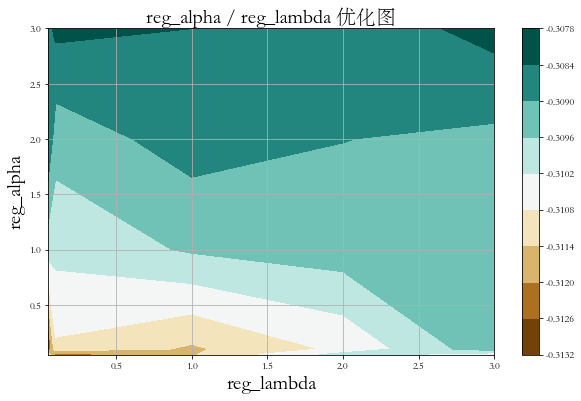

In [20]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
scores = grid_visualization.reshape(len(cv_params['reg_alpha']),len(cv_params['reg_lambda']))
plt.figure(figsize=(10,6))
cp = plt.contourf(cv_params['reg_lambda'],cv_params['reg_alpha'],scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('reg_alpha / reg_lambda 优化图',fontsize=20)
plt.xlabel('reg_lambda',fontsize=20)
plt.ylabel('reg_alpha',fontsize=20)
plt.grid(True)

In [21]:
%%time
#调参过程五：learning_rate
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'gpu:reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
learning_rate = optimized_GBM.best_params_['learning_rate']

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.4min finished


每次运行的结果如下:
 params:{'learning_rate': 0.01}  mean:-0.33845281754097956   std:0.004145529888499926   rank:5
 params:{'learning_rate': 0.05}  mean:-0.3070862830118963   std:0.005598156666992627   rank:2
 params:{'learning_rate': 0.07}  mean:-0.3067648635491671   std:0.005546751590428387   rank:1
 params:{'learning_rate': 0.1}  mean:-0.308193938160204   std:0.0059013898023072215   rank:3
 params:{'learning_rate': 0.2}  mean:-0.3199704756623593   std:0.005363764821884343   rank:4
---------------------------
参数的最佳取值：{'learning_rate': 0.07}
最佳模型得分:-0.3067648635491671
Wall time: 1min 25s


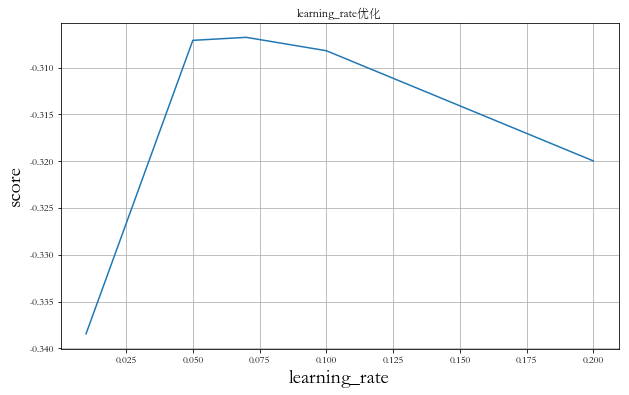

In [22]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('learning_rate优化')
plt.xlabel('learning_rate',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['learning_rate'], grid_visualization)
plt.grid(True)
plt.show()

In [23]:
%%time
#调参过程五：n_estimators最佳迭代次数
cv_params = {'n_estimators':[100 * i for i in range(1,10)]}
other_params = {'learning_rate':learning_rate, 'n_estimators': 500, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'seed': 0,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
                'gpu_id':0,'tree_method':'gpu_hist',#使用GPU加速
                'objective': 'gpu:reg:linear'}#业务类型
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=scoring_fuction, cv=cv_num, verbose=verbose, n_jobs=n_jobs)
optimized_GBM.fit(train_x, train_y.values)
print("每次运行的结果如下:")
for (r,i,j,k) in zip(optimized_GBM.cv_results_['rank_test_score'],optimized_GBM.cv_results_['params'],optimized_GBM.cv_results_['mean_test_score'],optimized_GBM.cv_results_['std_test_score']):
    print(" params:"+str(i)+"  mean:"+str(j),"  std:"+str(k)+"   rank:"+str(r))
print("---------------------------")
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
n_estimators = optimized_GBM.best_params_['n_estimators']

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  4.3min finished


每次运行的结果如下:
 params:{'n_estimators': 100}  mean:-0.32326887956837125   std:0.004459101120254528   rank:9
 params:{'n_estimators': 200}  mean:-0.31104091312374416   std:0.0049160031534969595   rank:8
 params:{'n_estimators': 300}  mean:-0.3080479253784881   std:0.005141231913905629   rank:6
 params:{'n_estimators': 400}  mean:-0.30701153347314064   std:0.005366539165291872   rank:3
 params:{'n_estimators': 500}  mean:-0.3067648635491671   std:0.005546751590428387   rank:1
 params:{'n_estimators': 600}  mean:-0.3068986396149277   std:0.005847620361965837   rank:2
 params:{'n_estimators': 700}  mean:-0.3072767700120413   std:0.005737708075310055   rank:4
 params:{'n_estimators': 800}  mean:-0.30791061168794004   std:0.005593723590386979   rank:5
 params:{'n_estimators': 900}  mean:-0.3083212265825775   std:0.0056650352059663825   rank:7
---------------------------
参数的最佳取值：{'n_estimators': 500}
最佳模型得分:-0.3067648635491671
Wall time: 4min 31s


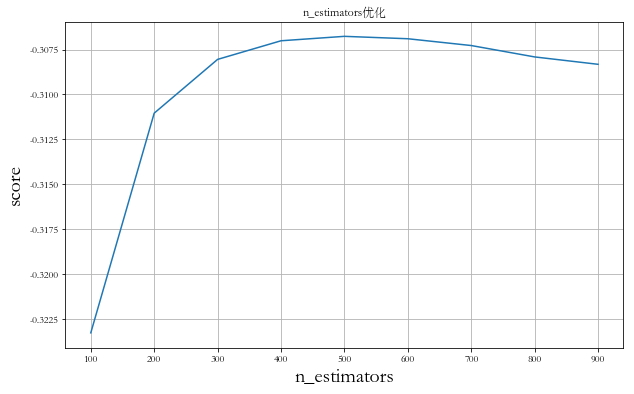

In [24]:
grid_visualization=[]
for grid_pair in optimized_GBM.cv_results_['mean_test_score']: 
    grid_visualization.append(grid_pair)
grid_visualization=np.array(grid_visualization)
plt.figure(figsize=(10,6))
plt.title('n_estimators优化')
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot(cv_params['n_estimators'], grid_visualization)
plt.grid(True)
plt.show()

In [25]:
# XGBoost训练过程，下面的参数就是刚才调试出来的最佳参数组合
print("最佳learning_rate:"+str(learning_rate))
print("最佳n_estimators:"+str(n_estimators))
print("最佳max_depth:"+str(max_depth))
print("最佳min_child_weight:"+str(min_child_weight))
print("最佳subsample:"+str(subsample))
print("最佳colsample_bytree:"+str(colsample_bytree))
print("最佳gamma:"+str(gamma))
print("最佳reg_alpha:"+str(reg_alpha))
print("最佳reg_lambda:"+str(reg_lambda))
model = xgb.XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight, seed=0,
                         subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
model.fit(train_x, train_y.values)
model.get_booster().save_model("model/l-model.model")

最佳learning_rate:0.07
最佳n_estimators:500
最佳max_depth:4
最佳min_child_weight:6
最佳subsample:0.8
最佳colsample_bytree:0.7000000000000001
最佳gamma:0.0
最佳reg_alpha:3
最佳reg_lambda:3


Text(0, 0.5, '特征重要性评分')

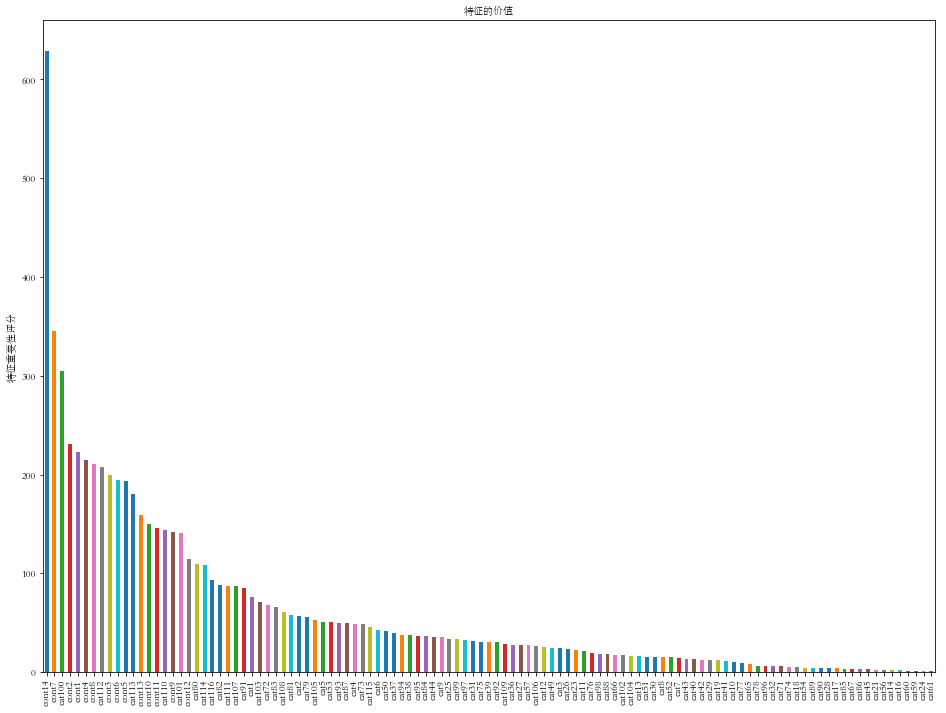

In [38]:
feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)  
feat_imp.plot(kind='bar',figsize=(16,12),fontsize=10)  
plt.title('特征的价值',{'size': 10})
plt.ylabel('特征重要性评分',{'size': 10})  

# 加载预测并查看指标¶

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
#加载测试数据
test = pd.read_csv('data/test.csv')
model=xgb.Booster(model_file="model/l-model.model")

In [27]:
#提取特征
all_features = [x for x in test.columns if x not in test.columns[0]]
cat_features = list(test.select_dtypes(include=['object']).columns)
#划分自变量和因变量
test_x = test[all_features]
#将离散数据转换成哑变量
for i in range(len(cat_features)):
    test_x[cat_features[i]] = test_x[cat_features[i]].astype('category').cat.codes

D:\work tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
test_x = xgb.DMatrix(test_x)

In [29]:
# 对测试集进行预测
result_list = model.predict(test_x)
result = np.exp(result_list).tolist()